# Setup

In [1]:
# Import packages
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Utilities
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

tf.__version__ # 2.x

'2.3.0'

# Load Data

In [2]:
# Load data from tf dataset - loads from cloud for the first time else loads from local
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True, data_dir="/home/nityan/tensorflow_datasets/")
train_dataset, test_dataset = dataset["train"], dataset["test"]

# View first batch review in train
for review, label in train_dataset.take(1):
    print("Review;", review)
    print()
    print("Label:", label)

# View first batch review in test
for review, label in test_dataset.take(1):
    print("Review;", review)
    print()
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)

Label: tf.Tensor(0, shape=(), dtype=int64)
Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's abs

In [3]:
print("Dataset Info:", info)

Dataset Info: tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/home/nityan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        't

# Setup Input Pipeline

In [4]:
# Set buffer size and batch size
BUFFER_SIZE = 10000
BATCH_SIZE = 32

# Create an optimized pipeline using cache and pre-fetch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# View first few reviews
for example, label in train_dataset.take(1):
    print("Reviews: ", example.numpy()[:3])
    print()
    print("Labels: ", label.numpy()[:3])

Reviews:  [b"This title seems more like a filming exercise than a film that should have been released to be seen by the public. For Dafoe and his wife it must have been fun working together in a film for the first time, without taking into consideration that people might actually watch it. I felt like it was 90mins wasted as I waited anxiously for a plot to develop, or even begin.<br /><br />Try to fit this film into a genre and you won't, because it lacks a beginning, middle or ending. I've seen 'arty' movies before and this doesn't even come close to being arty, abstract or original, it just seems to me to be completely pointless.<br /><br />I think it speaks for itself when the only persons that rated this film a 10 were the under 18 age group. No doubt for the constant pointless erotic scenes that the film was insistent on throwing at us. That is if you can call it erotic. It certainly didn't have taste."
 b'Several young Iranian women dress as boys and try to get into a World Cup 

# Create Text Encoder

In [5]:
# Set vocab metadata
VOCAB_SIZE = 1000
MAX_SEQUENCE_LENGTH = 512

# Create custom text processor to clean data
def text_processor(input_data):
    # Lower input text
    lowercase_text = tf.strings.lower(input_data)
    
    # Strip html tags
    stripped_text = tf.strings.regex_replace(lowercase_text, "<br />", " ")
    
    # Strip punctuation
    return tf.strings.regex_replace(
        stripped_text, "[%s]" % re.escape(string.punctuation), ""
    )

# Create a text encoder layer
encoder_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=text_processor,
    split="whitespace",
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Learn encoder on train text
encoder_layer.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# Get vocabulary
vocabulary = np.array(encoder_layer.get_vocabulary())
print("Vocabulary:", vocabulary[:20])

Vocabulary: ['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'was' 'as' 'for' 'with' 'movie' 'but' 'film']


# Modelling

In [7]:
def get_bilstm_model():
    # Instantiate sequence model
    model = tf.keras.Sequential()
    
    # Encoder layer
    model.add(encoder_layer)

    # Embedding layer
    model.add(layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    # Normalization and dropout regularizer
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    # Sequence processing layer
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    # Dense layers with dropout regularizer
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation="relu"))
    
    # We add the classifier on top
    model.add(layers.Dense(1))
    
    return model

In [8]:
# Define embedding size
EMBEDDING_DIM = 100

# Instantiate model
model = get_bilstm_model()

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Train and validation
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]
)

Epoch 1/10
782/782 [==============================] - 59s 76ms/step - loss: 0.6447 - accuracy: 0.5817 - val_loss: 0.4680 - val_accuracy: 0.7688
Epoch 2/10
782/782 [==============================] - 59s 76ms/step - loss: 0.4152 - accuracy: 0.8123 - val_loss: 0.3417 - val_accuracy: 0.8687
Epoch 3/10
782/782 [==============================] - 60s 77ms/step - loss: 0.3452 - accuracy: 0.8494 - val_loss: 0.3349 - val_accuracy: 0.8750
Epoch 4/10
782/782 [==============================] - 60s 77ms/step - loss: 0.3198 - accuracy: 0.8628 - val_loss: 0.4018 - val_accuracy: 0.8313
Epoch 5/10
782/782 [==============================] - 60s 77ms/step - loss: 0.2973 - accuracy: 0.8717 - val_loss: 0.3140 - val_accuracy: 0.8750
Epoch 6/10
782/782 [==============================] - 60s 77ms/step - loss: 0.2821 - accuracy: 0.8796 - val_loss: 0.3172 - val_accuracy: 0.8875
Epoch 7/10
782/782 [==============================] - 60s 76ms/step - loss: 0.2634 - accuracy: 0.8884 - val_loss: 0.2680 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


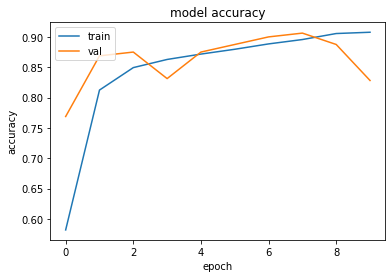

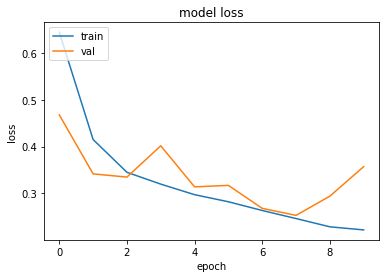

In [9]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [10]:
# Evaluate model on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

782/782 [==============================] - 24s 31ms/step - loss: 0.3080 - accuracy: 0.8597
Test Loss: 0.30800214409828186
Test Accuracy: 0.85971999168396


# Model Application

In [11]:
# Predict on a sample text
sample_text = ("The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.")

predictions = model.predict(np.array([sample_text]))
label_predicted = "Positive" if predictions[0][0] >= 0.0 else "Negative"

print("Review:", sample_text)
print("Lable:", predictions, label_predicted)

Review: The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.
Lable: [[-2.8515556]] Negative
